In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest

# ----------------------------
# PARAMETERS
# ----------------------------
np.random.seed(42)

n_clusters = 120             # number of clusters
cluster_size_min = 50
cluster_size_max = 80
baseline_rate = 0.08         # control prob
treatment_effect = 0.015     # uplift in treatment
alpha = 0.05

# ----------------------------
# SIMULATE CLUSTERS & USERS
# ----------------------------
clusters = np.arange(n_clusters)
assignment = np.random.choice([0, 1], size=n_clusters)  # 0=control, 1=treatment
cluster_sizes = np.random.randint(cluster_size_min, cluster_size_max+1, size=n_clusters)

records = []
for cid, size, treat in zip(clusters, cluster_sizes, assignment):
    cluster_effect = np.random.normal(0, 0.01)  # cluster heterogeneity
    for uid in range(size):
        user_noise = np.random.normal(0, 0.005)
        p = baseline_rate + (treatment_effect if treat == 1 else 0) + cluster_effect + user_noise
        p = np.clip(p, 0, 1)
        reacted = np.random.binomial(1, p)
        records.append([cid, treat, reacted])


In [3]:
df = pd.DataFrame(records, columns=["cluster", "treatment", "reacted"])

# ----------------------------
# CLUSTER-LEVEL ANALYSIS
# ----------------------------
cluster_means = df.groupby(["cluster", "treatment"])["reacted"].mean().reset_index()
ctrl = cluster_means[cluster_means["treatment"] == 0]["reacted"]
trt  = cluster_means[cluster_means["treatment"] == 1]["reacted"]

t_stat, p_val = stats.ttest_ind(ctrl, trt, equal_var=False)
print("Cluster-level Welch t-test")
print(f"Control mean: {ctrl.mean():.4f}, Treatment mean: {trt.mean():.4f}")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}\n")

Cluster-level Welch t-test
Control mean: 0.0800, Treatment mean: 0.0946
t = -2.423, p = 0.0170



In [4]:
# ----------------------------
# USER-LEVEL REGRESSION with CLUSTER-ROBUST SE
# ----------------------------
model = smf.ols("reacted ~ treatment", data=df).fit(cov_type='cluster', cov_kwds={'groups': df['cluster']})
print("Cluster-robust OLS regression")
print(model.summary(), "\n")

Cluster-robust OLS regression
                            OLS Regression Results                            
Dep. Variable:                reacted   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.867
Date:                Wed, 01 Oct 2025   Prob (F-statistic):             0.0169
Time:                        14:56:51   Log-Likelihood:                -1244.9
No. Observations:                7803   AIC:                             2494.
Df Residuals:                    7801   BIC:                             2508.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0799 

In [5]:
# ----------------------------
# NAIVE USER-LEVEL Z-TEST (WRONG if clustering exists, but shown for contrast)
# ----------------------------
success = df.groupby("treatment")["reacted"].sum().values
nobs = df.groupby("treatment")["reacted"].count().values
z_stat, z_pval = proportions_ztest(success, nobs)
print("Naive two-proportion z-test")
print(f"z = {z_stat:.3f}, p = {z_pval:.4f}\n")

Naive two-proportion z-test
z = -2.218, p = 0.0265



In [6]:

# ----------------------------
# EMPIRICAL POWER (by re-simulation)
# ----------------------------
def run_once():
    assign = np.random.choice([0,1], size=n_clusters)
    recs = []
    for cid, size, treat in zip(clusters, cluster_sizes, assign):
        cluster_effect = np.random.normal(0, 0.01)
        for uid in range(size):
            user_noise = np.random.normal(0, 0.005)
            p = baseline_rate + (treatment_effect if treat == 1 else 0) + cluster_effect + user_noise
            p = np.clip(p, 0, 1)
            reacted = np.random.binomial(1, p)
            recs.append([cid, treat, reacted])
    d = pd.DataFrame(recs, columns=["cluster","treatment","reacted"])
    cm = d.groupby(["cluster","treatment"])["reacted"].mean().reset_index()
    c = cm[cm["treatment"]==0]["reacted"]
    t = cm[cm["treatment"]==1]["reacted"]
    _, pv = stats.ttest_ind(c,t,equal_var=False)
    return pv < alpha

n_sims = 200
power_est = np.mean([run_once() for _ in range(n_sims)])
print(f"Empirical power estimate (n={n_sims} sims): {power_est:.3f}\n")

Empirical power estimate (n=200 sims): 0.580



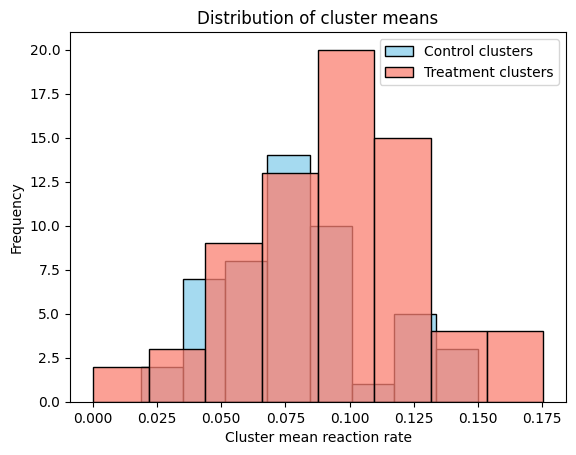

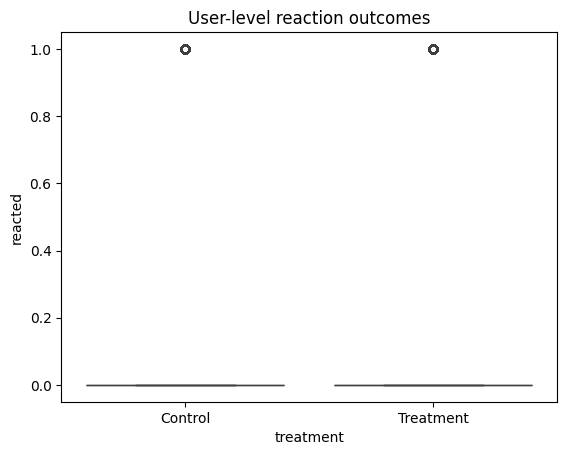

In [7]:
# ----------------------------
# VISUALIZATIONS
# ----------------------------
sns.histplot(ctrl, color="skyblue", label="Control clusters", kde=False)
sns.histplot(trt, color="salmon", label="Treatment clusters", kde=False)
plt.xlabel("Cluster mean reaction rate")
plt.ylabel("Frequency")
plt.title("Distribution of cluster means")
plt.legend()
plt.show()

sns.boxplot(x="treatment", y="reacted", data=df.replace({"treatment":{0:"Control",1:"Treatment"}}))
plt.title("User-level reaction outcomes")
plt.show()